# Project 3 - Reddit webscraping
by Liyena Yusoff

[Part I - Data Cleaning](Data_Cleaning.ipynb)

[Part II - Exploratory Data Analysis](EDA.ipynb)

## Contents:
* Modeling:
    - Multinomial Naive Bayes
    - Logistic Regression
    - Random Forest
    - Adaboost
* Summary of metrics
* Conclusion
* Business Recommendations

## Problem Statement
As the marketing team at Netflix, our primary objective is to boost website traffic and increase the number of sign-ups for our streaming service. To achieve this, we aim to develop a machine learning classifier to analyze Netflix and Disney+ Reddit posts, distinguishing between discussions related to Netflix and Disney+. The model will identify unique words and phrases associated specifically with Netflix, allowing us to understand what sets us apart in public perception.

## Goal

The goal of the project is to utilize the unique words and insights for the company's marketing campaigns to amplify our unique selling points, thereby driving more traffic to our website and increasing subscriber sign-ups.

## Stakeholders

1. Netflix Marketing Team
2. Netflix Content team

## Success metrics
* F1-score

We will be checking the success through the F1-score - taking the harmonic mean between the netflix posts that are predicted correctly out of all the netflix posts predicted and the netflix posts that are predicted correctly out of all the actual netflix posts.

In [107]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, RocCurveDisplay
from sklearn.metrics import recall_score, precision_score, classification_report, roc_auc_score

In [100]:
# I. Import Cleaned Data

# 1. Import data

In [2]:
df = pd.read_csv('datasets/cleaned_data_text_only.csv')
df.head()

,readable_time,subreddit,author,title,selftext,text,proc_text,proc_text_lem,char_length,word_count
0,2021-04-24 15:24:04,1,N3DSdude,/r/Netflix Discord Server,We are pleased to announce we have affiliated ...,/r/Netflix Discord Server We are pleased to an...,r netflix discord server pleased announce affi...,r netflix discord server pleased announce affi...,178,24
1,2023-02-02 09:35:27,1,UniversallySecluded,Netflix Announces Plans to Crack Down on Passw...,> **Any post relating to this thread will now ...,Netflix Announces Plans to Crack Down on Passw...,netflix announces plans crack password sharing...,netflix announce plan crack password sharing m...,576,78
2,2023-09-11 23:00:51,1,Scully__,Any tips for de-morbiding your feed?,This is on behalf of a friend although my feed...,Any tips for de-morbiding your feed? This is o...,tips de morbiding feed behalf friend although ...,tip de morbide feed behalf friend although fee...,301,44
3,2023-09-11 15:57:38,1,ironshadowy,Why did netflix remove some profile pictures?,Was using one of the one piece profile picture...,Why did netflix remove some profile pictures? ...,netflix remove profile pictures using one one ...,netflix remove profile picture use one one pie...,174,24
4,2023-09-12 00:19:47,1,ussjtrunksftw,One Piece Issue?,I saw episode one and two earlier and they wer...,One Piece Issue? I saw episode one and two ear...,one piece issue saw episode one two earlier fi...,one piece issue see episode one two early fine...,217,34


# 2. Pre-processing & Modeling
1. Split `df` into train and test data.
2. Vectorize the text using CountVectorizer or TF-IDF Vectorizer
3. The models we will be testing on are:
- Naive Bayes Classifier,
- Logistic Regression,
- Random Forest Classifier, and
- AdaBoost

In [4]:
X = df['proc_text_lem']
y = df['subreddit']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [6]:
X_train.shape

(2266,)

In [7]:
y_train.shape

(2266,)

In [164]:
# forming a function to vectorize and train the dataset using a pipeline and GridSearch
def model(vectorizer, vec_name, model, model_name, X, y, params, cv_val):
    
    # instantiating the pipeline
    pipe = Pipeline([(vec_name, vectorizer),
                    (model_name, model)
                    ])
    print('Vectorizer: ', vec_name)
    print('Modeling... ', model_name)
    
    # instantiating the gridsearch with the parameters and the score to be obtained
    pipe_gs = GridSearchCV(pipe,
                         params,
                         cv=cv_val,
                         error_score='raise',
                        scoring='f1')
    
    # training the dataset
    pipe_gs.fit(X, y)
    
    # getting the predicted values for the train and test sets
    y_pred_train = pipe_gs.predict(X)
    y_pred_test = pipe_gs.predict(X_test)

    # printing the best parameters and the scores
    print('Best parameters: ', pipe_gs.best_params_)
    print(f'F1 score (train): {pipe_gs.score(X,y):.3f}')
    print(f'F1 score (test): {pipe_gs.score(X_test,y_test):.3f}')
    print(f'Accuracy (train): {accuracy_score(y,y_pred_train):.3f}')
    print(f'Accuracy (test): {accuracy_score(y_test, y_pred_test):.3f}')
    print(f'Precision (train): {precision_score(y,y_pred_train):.3f}')
    print(f'Precision (test): {precision_score(y_test, y_pred_test):.3f}')
    print(f'Recall (train): {recall_score(y,y_pred_train):.3f}')
    print(f'Recall (test): {recall_score(y_test, y_pred_test):.3f}')
    
    # plotting the Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test),
                              display_labels = ['Disney+', 'Netflix'] )
    disp.plot()
    
    # plotting the ROC Curve
    roc_display = RocCurveDisplay.from_estimator(pipe_gs, X_test, y_test)
    plt.plot([0, 1], [0, 1], label='baseline', linestyle='--')

#### a. Multinomial Naive Bayes

Multinomial Naive Bayes is a text classification algorithm based on Bayes' theorem. It's "naive" because it assumes independence between features (e.g., word frequencies). It models term frequencies using a multinomial distribution and estimates class probabilities (either Netflix or Disney+ in this project) based on training data.

In [70]:
Pipeline([('cvec', CountVectorizer()),
                ('nb', MultinomialNB())
                ]).get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True,
 'nb__force_alpha': 'warn'}

Vectorizer:  cvec
Modeling...  nb
Best parameters:  {'cvec__max_df': 0.7, 'cvec__max_features': 4000, 'cvec__ngram_range': (1, 2), 'nb__alpha': 0.1}
F1 score (train): 0.934
F1 score (test): 0.907
Accuracy (train): 0.921
Accuracy (test): 0.886
Precision (train): 0.880
Precision (test): 0.835
Recall (train): 0.994
Recall (test): 0.993
Script execution time: 58.02 seconds


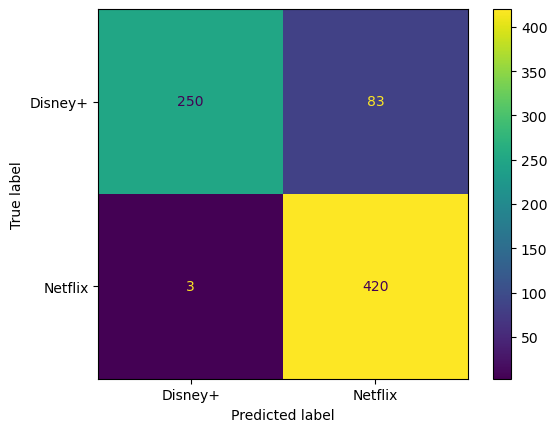

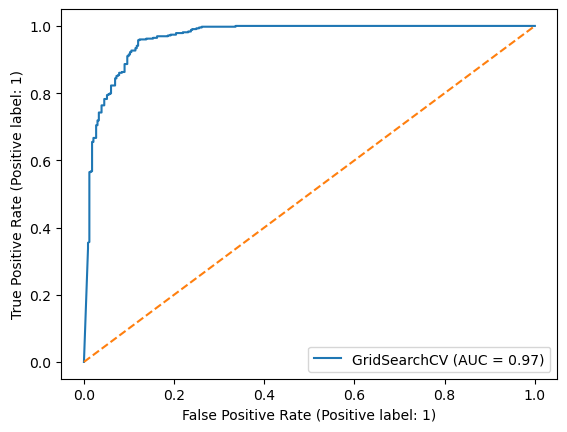

In [165]:
# Using CountVectorizer as a transformer and modeling using Naive Bayes

# Start the timer
start_time = time.time()

cvec_nb_params = {'cvec__ngram_range': [(1, 1), (1, 2)],
                'cvec__max_features': [1000, 1800, 2000, 4000],
                  'cvec__max_df': [0.7, 0.8, 0.9],
                'nb__alpha': [0.1, 1.0, 2.0, 5.0]
}

cvec_nb = model(CountVectorizer(), 'cvec',
      MultinomialNB(), 'nb',
      X_train, y_train,
     cvec_nb_params,
     5)
# run model
cvec_nb

# Calculate the elapsed time
end_time = time.time()
execution_time = end_time - start_time

# Print the execution time
print("Script execution time: {:.2f} seconds".format(execution_time))

Vectorizer:  tfidf
Modeling...  nb
Best parameters:  {'nb__alpha': 0.1, 'tfidf__max_df': 0.7, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 2)}
F1 score (train): 0.948
F1 score (test): 0.902
Accuracy (train): 0.940
Accuracy (test): 0.882
Precision (train): 0.910
Precision (test): 0.844
Recall (train): 0.990
Recall (test): 0.969
Script execution time: 74.26 seconds


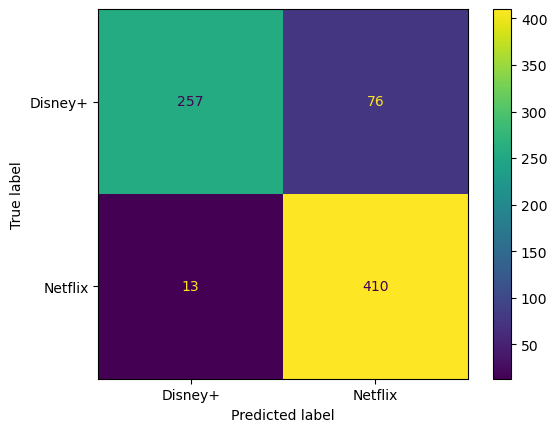

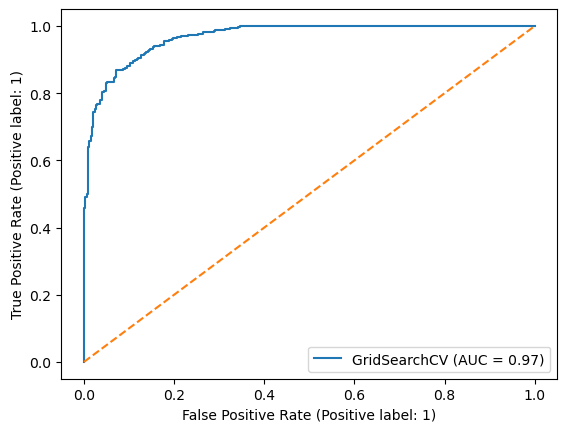

In [167]:
# Using TF-IDF Vectorizer as a transformer and modeling using Naive Bayes

# Start the timer
start_time = time.time()

tf_nb_params = {'tfidf__ngram_range': [(1, 1), (1, 2)],
                'tfidf__max_features': [1000, 1500, 1800, 3000],
                'tfidf__max_df': [0.7, 0.8, 0.9],
                  #'tfidf__min_df': [0.1, 0.2],
                'nb__alpha': [0.1, 1.0, 2.0, 5.0, 10.0]
               }

tf_nb = model(TfidfVectorizer(), 'tfidf',
      MultinomialNB(), 'nb',
      X_train, y_train,
     tf_nb_params,
     5)

# run model
tf_nb

# Calculate the elapsed time
end_time = time.time()
execution_time = end_time - start_time

# Print the execution time
print("Script execution time: {:.2f} seconds".format(execution_time))

#### b. Logistic Regression

Logistic Regression is a statistical model used for binary classification tasks. It models the probability of an input belonging to one of two classes using the logistic function. In this project, this model will classify the words into either words that came from Netflix subreddit posts or Disney+ subreddit posts.

In [31]:
Pipeline([('cvec', CountVectorizer()),
                ('logreg', LogisticRegression())
                ]).get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('logreg', LogisticRegression())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'logreg': LogisticRegression(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'logreg__C': 1.0,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__l1_ratio': None,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'auto',
 'logreg__n_jobs': None,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solver': 'lbfgs',
 'logreg__tol':

Vectorizer:  cvec
Modeling...  logreg
Best parameters:  {'cvec__max_features': 1000, 'cvec__ngram_range': (1, 1), 'logreg__C': 0.01}
F1 score (train): 0.940
F1 score (test): 0.910
Accuracy (train): 0.931
Accuracy (test): 0.896
Precision (train): 0.922
Precision (test): 0.877
Recall (train): 0.957
Recall (test): 0.946
Script execution time: 11.86 seconds


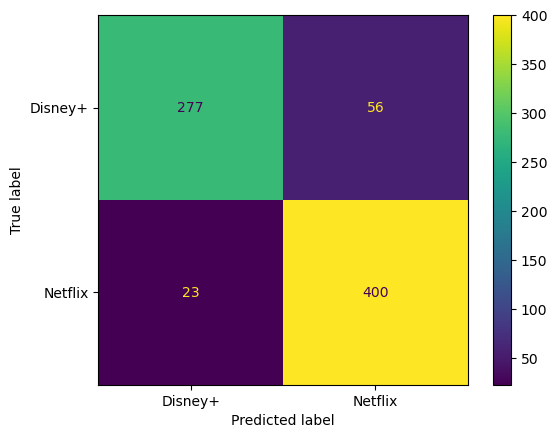

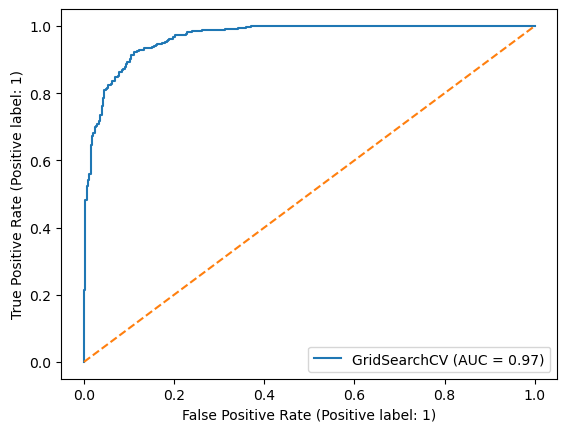

In [168]:
# Using CountVectorizer as a transformer and modeling using Logistic Regression

# Start the timer
start_time = time.time()

cvec_logreg_params = {'cvec__ngram_range': [(1, 1), (1,2)],
                'cvec__max_features': [500, 800, 1000],
                    'logreg__C': [0.01, 0.1, 1.0]
}

cvec_logreg = model(CountVectorizer(), 'cvec',
                      LogisticRegression(max_iter=1000), 'logreg',
                      X_train, y_train,
                     cvec_logreg_params,
                     5)

# run model
cvec_logreg

# Calculate the elapsed time
end_time = time.time()
execution_time = end_time - start_time

# Print the execution time
print("Script execution time: {:.2f} seconds".format(execution_time))

Vectorizer:  tfidf
Modeling...  logreg
Best parameters:  {'logreg__C': 1.0, 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 1)}
F1 score (train): 0.954
F1 score (test): 0.918
Accuracy (train): 0.947
Accuracy (test): 0.903
Precision (train): 0.926
Precision (test): 0.872
Recall (train): 0.985
Recall (test): 0.969
Script execution time: 11.47 seconds


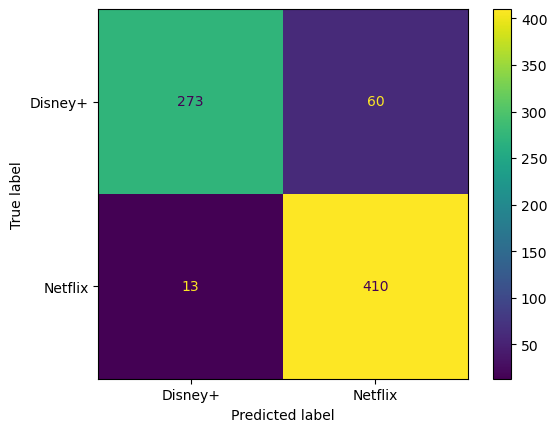

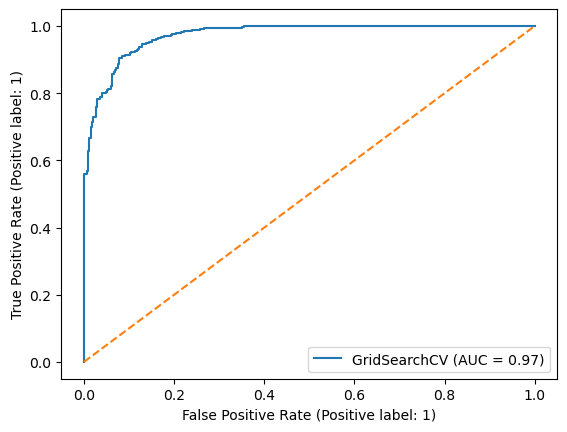

In [169]:
# Using TF-IDF Vectorizer as a transformer and modeling using Logistic Regression

# Start the timer
start_time = time.time()

tf_logreg_params = {'tfidf__ngram_range': [(1, 1), (1,2)],
                'tfidf__max_features': [500, 800, 1000],
                    'logreg__C': [0.01, 0.1, 1.0]
}

tf_logreg = model(TfidfVectorizer(), 'tfidf',
                  LogisticRegression(max_iter=1000), 'logreg',
                  X_train, y_train,
                 tf_logreg_params,
                 5)

# run model
tf_logreg

# Calculate the elapsed time
end_time = time.time()
execution_time = end_time - start_time

# Print the execution time
print("Script execution time: {:.2f} seconds".format(execution_time))

#### c. Random Forest Classifier

Random Forest is an ensemble learning method that combines multiple decision trees to make predictions. It is robust, handles non-linear relationships well. Its strength lies in handling complex datasets and maintaining good predictive performance.

In [82]:
Pipeline([('cvec', CountVectorizer()),
                ('rf', RandomForestClassifier())
                ]).get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'rf': RandomForestClassifier(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_est

Vectorizer:  cvec
Modeling...  rf
Best parameters:  {'cvec__max_df': 0.9, 'cvec__max_features': 1000, 'cvec__ngram_range': (1, 1), 'rf__ccp_alpha': 0.01, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}
F1 score (train): 0.871
F1 score (test): 0.872
Accuracy (train): 0.836
Accuracy (test): 0.837
Precision (train): 0.777
Precision (test): 0.779
Recall (train): 0.991
Recall (test): 0.991
Script execution time: 266.45 seconds


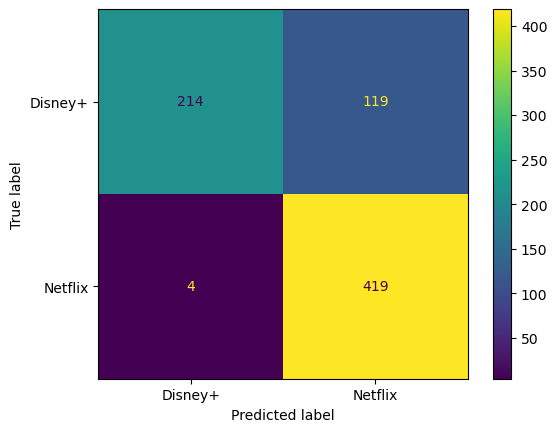

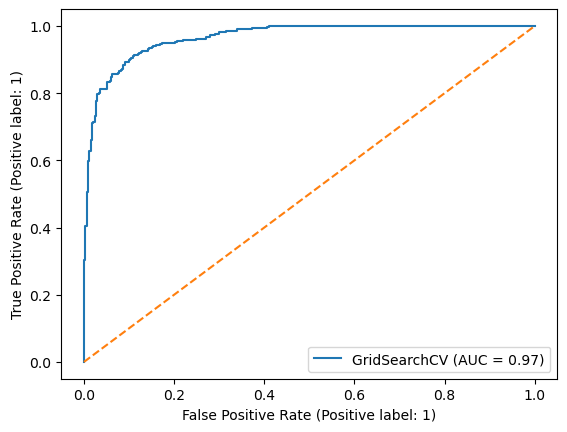

In [178]:
# Using Count Vectorizer as a transformer and modeling using Randomm Forest

# Start the timer
start_time = time.time()

cvec_rf_params = {'cvec__ngram_range': [(1, 1), (1, 2)],
                  'cvec__max_features': [1000, 1500, 3000],
                'cvec__max_df': [0.7, 0.8, 0.9],
                  # 'cvec__min_df': [0.1, 0.2],
                  'rf__min_samples_split': [3, 5],
                'rf__n_estimators': [100, 200],
                # 'rf__max_depth': [100, 150],
                # 'rf__max_leaf_nodes': [50, 100, 150],
                  'rf__ccp_alpha': [0.01, 0.05, 0.1]
}


cvec_rf = model(CountVectorizer(), 'cvec',
                  RandomForestClassifier(n_jobs=-1), 'rf',
                  X_train, y_train,
                cvec_rf_params,
                 5)

# run model
cvec_rf

# Calculate the elapsed time
end_time = time.time()
execution_time = end_time - start_time

# Print the execution time
print("Script execution time: {:.2f} seconds".format(execution_time))

Vectorizer:  tfidf
Modeling...  rf
Best parameters:  {'rf__max_depth': 100, 'rf__max_leaf_nodes': 50, 'rf__max_samples': 150, 'rf__n_estimators': 200, 'tfidf__max_features': 800, 'tfidf__ngram_range': (1, 1)}
F1 score (train): 0.920
F1 score (test): 0.895
Accuracy (train): 0.909
Accuracy (test): 0.878
Precision (train): 0.905
Precision (test): 0.867
Recall (train): 0.936
Recall (test): 0.924
Script execution time: 959.11 seconds


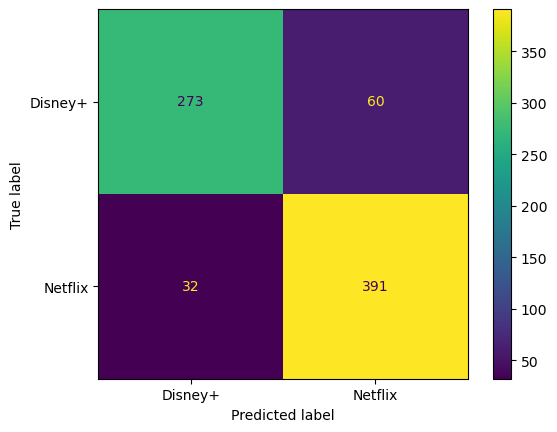

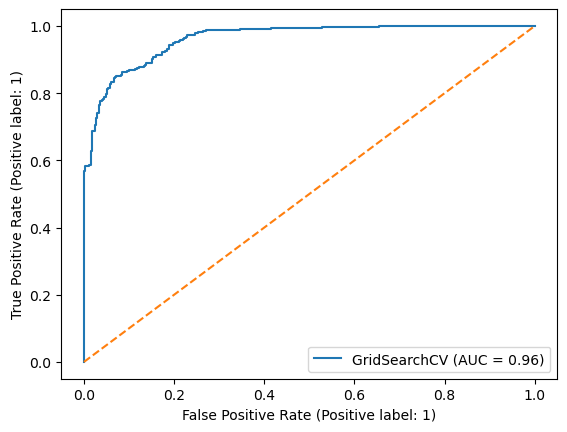

In [173]:
# Using TF-IDF Vectorizer as a transformer and modeling using Randomm Forest

# Start the timer
start_time = time.time()

tf_rf_params = {'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
                'tfidf__max_features': [800, 1000, 2000],
                'rf__n_estimators': [100, 200, 500],
                'rf__max_depth': [50, 100],
                'rf__max_leaf_nodes': [50, 100, 150],
                'rf__max_samples': [100, 150]
}

tf_rf = model(TfidfVectorizer(), 'tfidf',
              RandomForestClassifier(), 'rf',
              X_train, y_train,
             tf_rf_params,
             5)

# run model
tf_rf

# Calculate the elapsed time
end_time = time.time()
execution_time = end_time - start_time

# Print the execution time
print("Script execution time: {:.2f} seconds".format(execution_time))

#### d. AdaBoost

In [102]:
Pipeline([('cvec', CountVectorizer()),
                ('ab', AdaBoostClassifier())
                ]).get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('ab', AdaBoostClassifier())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'ab': AdaBoostClassifier(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'ab__algorithm': 'SAMME.R',
 'ab__base_estimator': 'deprecated',
 'ab__estimator': None,
 'ab__learning_rate': 1.0,
 'ab__n_estimators': 50,
 'ab__random_state': None}

Vectorizer:  cvec
Modeling...  ab
Best parameters:  {'ab__learning_rate': 0.1, 'ab__n_estimators': 80, 'cvec__max_features': 1000, 'cvec__ngram_range': (1, 1)}
F1 score (train): 0.975
F1 score (test): 0.913
Accuracy (train): 0.972
Accuracy (test): 0.899
Precision (train): 0.970
Precision (test): 0.885
Recall (train): 0.979
Recall (test): 0.943
Script execution time: 77.43 seconds


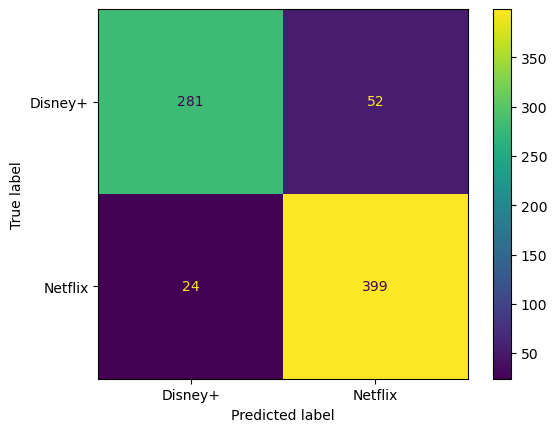

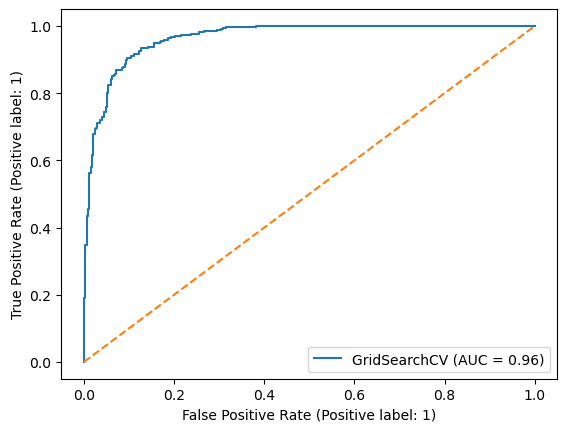

In [252]:
# Using Count Vectorizer as a transformer and modeling using Adaboost with Naive Bayes as estimator

# Start the timer
start_time = time.time()

cvec_ab_params = {'cvec__ngram_range': [(1, 1), (1, 2)],
                'cvec__max_features': [500, 800, 1000],
                'ab__learning_rate': [0.1, 1.0, 5.0],
                 'ab__n_estimators': [80, 100, 150]
}

cvec_ab_nb = model(CountVectorizer(), 'cvec',
                  AdaBoostClassifier(estimator=MultinomialNB(alpha=0.1)), 'ab',
                  X_train, y_train,
                 cvec_ab_params,
                 5)
# run model
cvec_ab_nb

# Calculate the elapsed time
end_time = time.time()
execution_time = end_time - start_time

# Print the execution time
print("Script execution time: {:.2f} seconds".format(execution_time))

Vectorizer:  tfidf
Modeling...  ab
Best parameters:  {'ab__learning_rate': 1.0, 'ab__n_estimators': 50, 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 1)}
F1 score (train): 0.944
F1 score (test): 0.923
Accuracy (train): 0.935
Accuracy (test): 0.909
Precision (train): 0.910
Precision (test): 0.878
Recall (train): 0.980
Recall (test): 0.972
Script execution time: 73.25 seconds


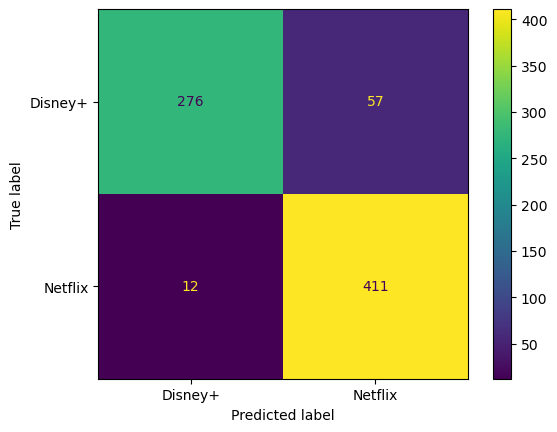

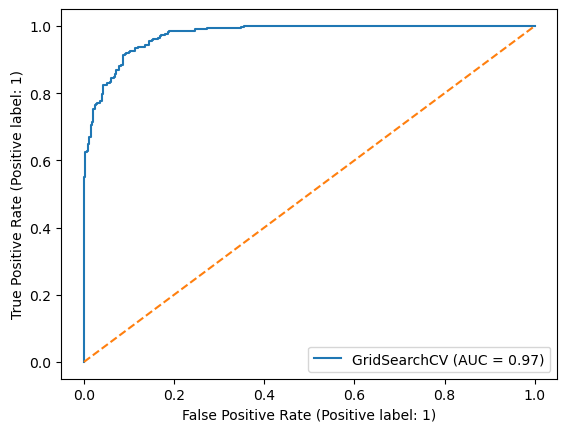

In [287]:
# Using TF-IDF Vectorizer as a transformer and modeling using Adaboost and Naive Bayes as the estimator

# Start the timer
start_time = time.time()

tf_ab_params = {'tfidf__ngram_range': [(1, 1), (1, 2)],
                'tfidf__max_features': [500, 800, 1000],
                'ab__learning_rate': [0.1, 1.0, 5.0],
                 'ab__n_estimators': [25, 50, 80, 100]
                
                }

tf_ab_nb = model(TfidfVectorizer(), 'tfidf',
              AdaBoostClassifier(estimator=MultinomialNB(alpha=0.1)), 'ab',
              X_train, y_train,
             tf_ab_params,
             5)

# run model
tf_ab_nb

# Calculate the elapsed time
end_time = time.time()
execution_time = end_time - start_time

# Print the execution time
print("Script execution time: {:.2f} seconds".format(execution_time))

### Evaluation metrics

| Vectorizer  | Model     | F1-score (train)  | F1-score (test)  | Accuracy score (train) | Accuracy (test) | Precision (train) | Precision (test) | Recall (train) | Recall (test) |
|-------------|-----------|-------------------|------------------|--------|---------|---------|---------|--------|---------|
| Cvec     | Random Forest  (baseline)  | 0.871 |  0.872 | 0.836 | 0.837 |0.777|0.779|0.991|0.991|
| TF-IDF   | Random Forest    | 0.920  | 0.895  | 0.909   | 0.878   |0.905|0.867|0.936|0.924|
| Cvec     | Naive Bayes      |    0.934   |  0.907    | 0.921 | 0.886 |0.880|0.835|0.994|0.993| 
| TF-IDF   | Naive Bayes  |    0.948    |  0.902  | 0.940 | 0.882 |0.910|0.844|0.990|0.969|
| Cvec     | Logistic Regression      |  0.940    |   0.910  | 0.931 | 0.896 |0.922|0.877|0.957|0.946|
| TF-IDF | Logistic Regression      |  0.954     |  0.918   | 0.947 | 0.903 |0.926|0.872|0.985|0.969| 
| Cvec     | Adaboost    | 0.975 |  0.913 | 0.972 | 0.899 |0.970|0.885|0.979|0.943|
| TF-IDF   | Adaboost    | 0.944  | 0.923  | 0.935   | 0.909   | 0.910 | 0.878 | 0.980 | 0.972 | 

In general, all the models have similar ROC score of 0.96 or 0.97. This means that the models are able to predict and label 96%-97% of the words correctly.

# 3. Summary

| Vectorizer  | Model         | F1-score (train)  | F1-score (test)  | Time |
|-------------|---------------|-------------------|------------------|----------|
| Cvec     | Random Forest  (baseline)  | 0.871 |  0.872 | 266.45s |
| TF-IDF   | Random Forest    | 0.920  | 0.895  | 959.11s |
| Cvec     | Naive Bayes      |    0.934   |  0.907 | 58.02s |
| TF-IDF   | Naive Bayes  |    0.948    |  0.902  | 74.26s |
| Cvec     | Logistic Regression      |  0.940    |   0.910  | 11.86s |
| **TF-IDF** | **Logistic Regression** |  0.954 |  **0.918**  | **11.47s** |
| Cvec     | Adaboost    | 0.975 |  0.913 | 77.43s|
| TF-IDF   | Adaboost    | 0.944  | 0.923 | 73.25s |

From the models, generally, the models with TF-IDF vectorizer performs better. The model of choice is **Logistic Regression** because it works faster than the best performing model and this is important because larger data will be processed and we need a shorter amount of time to do so. Comparing it to the baseline score, this model performed **4.6%** better. A score of 0.918 means that the model could classify **91.8%** of the words correctly. 

# 4. Insights

* **Feature importance from Logistic Regression**

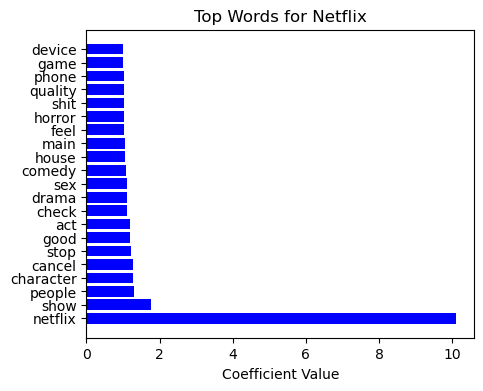

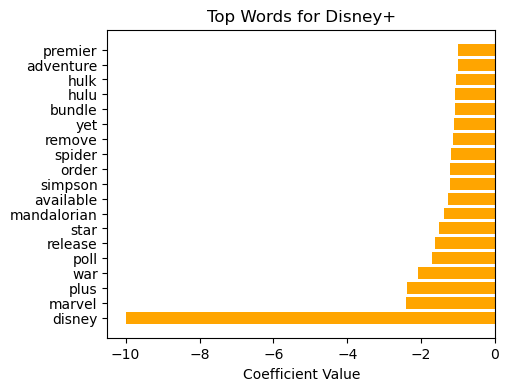

In [258]:
# Using the best parameters from the GridSearch

tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1,1))

logreg = LogisticRegression(C = 1.0, max_iter=1000)

# Create a pipeline
pipe = Pipeline([
    ('tfidf', tfidf),
    ('logreg', logreg)
])

# Fit the pipeline to the train data
pipe.fit(X_train, y_train)

# Access the coefficients from the model
coefficients = pipe.named_steps['logreg'].coef_[0]

# Access the features from the word matrix
features = pipe.named_steps['tfidf'].get_feature_names_out()

# Get top N features based on the magnitude of coefficients
top_n_indices = np.argsort(np.abs(coefficients))[-40:]

# Extract the top N feature names and their coefficients
top_features = [features[i] for i in top_n_indices]
top_coefficients = [coefficients[i] for i in top_n_indices]

# Split top_features and top_coefficients into two lists: one for class 1 and one for class 0
class_1_features = [feature for feature, coef in zip(top_features, top_coefficients) if coef > 0]
class_1_coefficients = [coef for coef in top_coefficients if coef > 0]

class_0_features = [feature for feature, coef in zip(top_features, top_coefficients) if coef < 0]
class_0_coefficients = [coef for coef in top_coefficients if coef < 0]

# Plot top words for class 1 (Netflix)
plt.figure(figsize=(5, 4))
plt.barh(class_1_features, class_1_coefficients, color='blue')
plt.xlabel('Coefficient Value')
plt.title('Top Words for Netflix')
plt.gca().invert_yaxis()
plt.show()

# Plot top words for class 0 (Disney+)
plt.figure(figsize=(5, 4))
plt.barh(class_0_features, class_0_coefficients, color='orange')
plt.xlabel('Coefficient Value')
plt.title('Top Words for Disney+')
plt.gca().invert_yaxis()
plt.show()

From the feature importance, it seems that the posts from the Netflix subreddit have concerns regarding the content produced by Netflix through words like `stop` and `cancel`. 

For the words from Disney+, we can see that there are words such as `hulu` and `bundle` which suggest that having other streaming services on the platform could also be a point of attraction for the subscriptions and viewership.

Linkning the two points above, Netflix could explore collaborating with other streaming services to provide streaming bundles to their users and as a way to diversify its content.

## Limitations

1. **Require periodic retraining**

Trends change with time so as the topics discussed online. There is a need for the dataset to be retrained regularly according to trends.

2. **Outliers**

Outliers are difficult to detect in large text data and removed. If there are a large number of outliers, it might affect the model training and performance. 

# 5. Business recommendations

1. **Boost Marketing**

Using the words that we have gotten from the model, we could optimize the 'People also ask' section and optimize image SEO on search engines that could redirect those words from Disney+ to the shows on Netflix. 

2. **Expand Original Productions**

To counter the response from the cancellation of expensive productions, the team can channel the fanbase of these cancelled productions to other productions that have some similarities or by producing new original series or movies. This could be paired with the insights and that we have gotten from the model to also attract viewers from our competitors. This accentuates the brand's uniqueness of producing original titles.

3. **Boost Non-English productions**

Having a bigger diversity or titles and productions from different countries than Disney+, we could push forward the titles of other languages that are associated with the words that we can find from the Disney+, introducing new shows to each user.

## Future Steps

1. **Sentiment Analysis**

This project could further be worked on through sentiment analysis so that we could narrow down the needs of the users and reconcile their needs with Netflix's contents and business.

2. **Extend analysis to other OTT services**

This model could also be applied to other Over-The-Top (OTT) services such as Prime Video and Apple TV in Search Engine Optimization (SEO).

## Conclusion

Our goal was to create a robust binary classifier that is able to distinguish between posts associated with Netflix and Disney+.

Our classifier model has yielded impressive results with an F1 score of 0.918. This achievement not only enhances Netflix's ability to attract higher traffic but also augments the quality of content we offer to subscribers, improving user experience.